# **TP Wavelets**

In this TP, we will work on some fundamental concepts in Wavelets and compression of images.

First we'll briefly check the limitations of the Fourier transform. We'll then check some fundamental properties of a family of Wavelets and compute the Wavelet transform of a very simple signal. In the second part of the TP, we will use the DWT to compress and image.

Make sure to sequentially run all the cells in each section, so that the intermediate variables / packages will carry over to the next cell

We recommend you save a copy of this colab in your drive so you don't lose progress!

**Note 1:** As mentioned in the course and since there's not any policy regarding ChatGPT at Télécom level yet, you can use it. However, using ChatGPT without understanding their outputs is not OK, and will be penalized accordingly in your grade. Please be sure of all the functions you'll use.

**Note 2:** Several points have associated questions. When answering these questions, all responses should be properly justified. ChatGPT answers are very easy to spot.

**Note 3:** Always plot the functions and outputs you're generating. If the output or function is not properly plotted/shown, this will reduce points in your grade.

# Setup
First, we install PyWavelets

In [2]:
%pip install PyWavelets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pywt , pywt.data
import numpy as np
import scipy.integrate as integrate
import scipy.signal as sg
import io
pywt.__version__

'1.7.0'

# Important
Google Colab is an interesting tool to try things out quickly. However, Google Colab and more general Notebooks are not meant to be an Integrated Development Environment (IDE). For a real job, please use an actual IDE like PyCharm or VS Code.

# Limitation of the Fourier Transform
*   Create a sinusoidal signal of 2.5 seconds of duration.
*   Set up a sampling rate of 20kHz. The signal should be divided in 5 parts of 0.5 seconds of duration each.
*  The signal should have the following frequencies in this order {10 Hz, 30 Hz, 60 Hz, 30 Hz, 10 Hz}.

In [4]:
#The signal as described above 

Fs = 20_000
timesteps = np.arange(0,2.5,1/Fs)

# !danger, Verify if this is correct later
sin_signal = np.append(np.sin(2*np.pi*timesteps[0:10_000]*(10)),
                    [
                    np.sin(2*np.pi*timesteps[10_000:20_000]*30),
                    np.sin(2*np.pi*timesteps[20_000:30_000]*60),                                                        
                    np.sin(2*np.pi*timesteps[30_000:40_000]*30),
                    np.sin(2*np.pi*timesteps[40_000:50_000]*10)]  
                    )

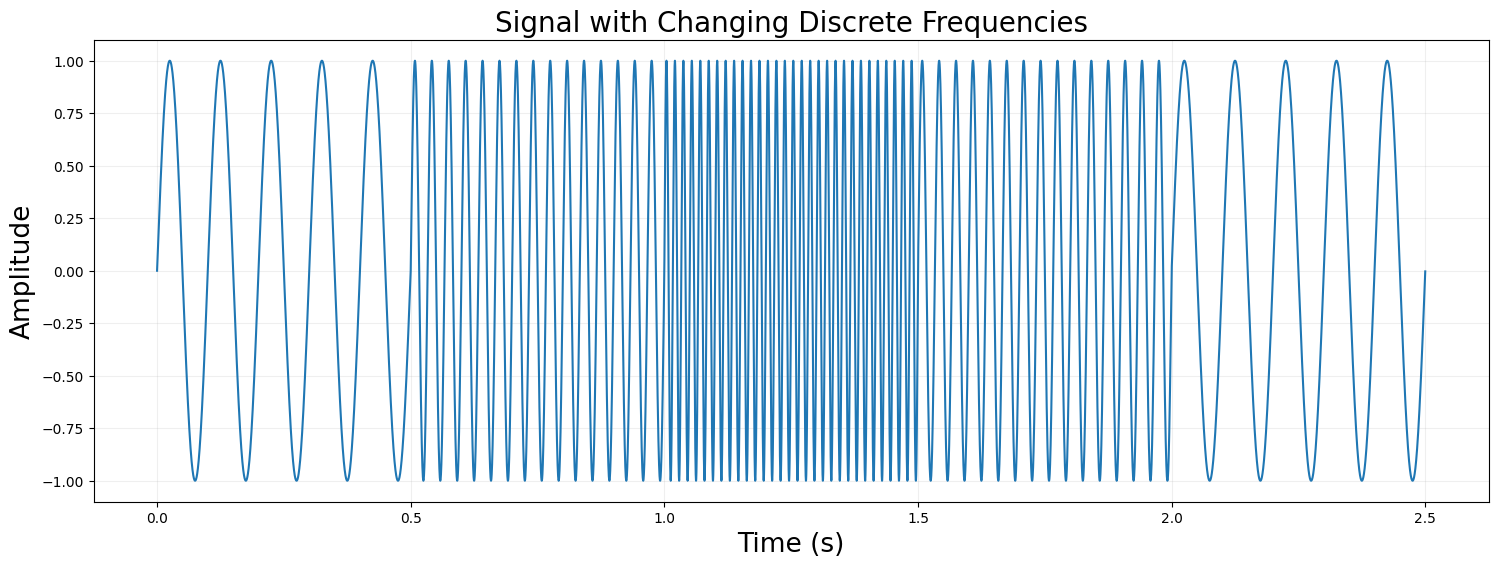

In [5]:
import matplotlib
import matplotlib.pyplot as plt

font_size = 20

# PLotting the results here
plt.figure(figsize=(18, 6))
plt.plot(timesteps, sin_signal, linewidth=1.5)
plt.title('Signal with Changing Discrete Frequencies', fontsize=font_size)
plt.xlabel('Time (s)', fontsize=font_size-1)
plt.ylabel('Amplitude', fontsize=font_size-1)
plt.grid(alpha=0.2)

Now, you should compute the Discrete Fourier Transform of the signal. You can use any library from Python you prefer. You might need to cut the x-axis in the Fourier transform up to 100 Hz in the visualization. Please check https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html and https://numpy.org/doc/stable/reference/generated/numpy.fft.fftfreq.html

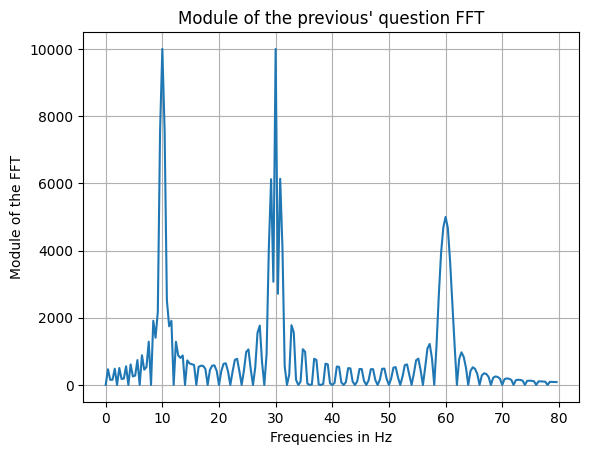

In [6]:
# FFT of the previous sin signal
FFT = np.fft.fft(sin_signal)
FFTOMODULE = np.abs(FFT)
frequencies = np.fft.fftfreq(FFT.size,1/Fs)

# !danger, the frequencies shown below do not correspond to theoritical values, to reverify


plt.plot(frequencies[:200],FFTOMODULE[:200])
plt.ylabel("Module of the FFT")
plt.xlabel("Frequencies in Hz")
plt.title("Module of the previous' question FFT")
plt.grid()
plt.show()

**QUESTIONS**

1) Does the established sampling rate satisfy the Nyquist-Shannon sampling theorem to avoid aliasing? Please justify.

2) What can you say from the signal looking **only** at the Fourier transform?

3) Can you be certain about the location of some frequency component in the time domain? Why?

**YOUR ANSWERS HERE:**

1)

2)

3)

# **Mother Wavelet**
As we saw in the course, a wavelet is not just a function but a whole family of functions that satisfy certain requirements. In this part of the TP we're gonna work with the Morlet wavelet defined as follows: $\Psi(t)=k e^{iw_0t}e^{-\frac{1}{2}(\frac{t}{\sigma})^2}$. Please generate a Morlet wavelet in Python **WITHOUT using PyWavelets** with the following parameters:

-Center frequency of the wavelet = 10 Hz

-Sampling rate $\eta$ = 20000 Hz

-$k=\frac{1}{\sqrt{\eta}}$

-$\sigma = 0.1$

You can generate the wavelet between -1 and 1 seconds, so the time duration of the wavelet is 2 seconds. For this part, you just need to generate the real part of the wavelet.

Text(0, 0.5, 'Amplitude')

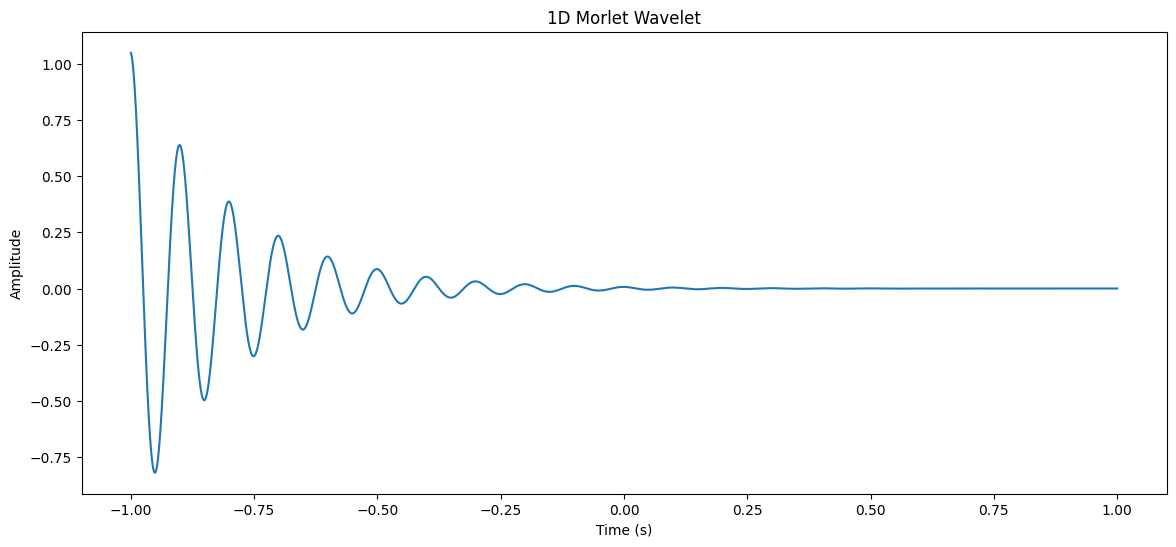

In [8]:
# Morlet Wavelet Here
eta = 20_000
timesteps = np.linspace(-eta,eta,10000)/eta
sigma = 0.1
psi = (1/np.sqrt(eta)) * np.exp(2j*np.pi*10*timesteps) * np.exp((-1/2)*(timesteps/sigma))

# Plot the real part of the Morlet wavelet in 1D
plt.figure(figsize=(14, 6))

plt.plot(timesteps,np.real(psi))
plt.title('1D Morlet Wavelet')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

Please show that the mother wavelet we just created satisfies the admissibility and the finite energy conditions:

In [9]:
# Let us verify the admissibility condition
mean = integrate.quad(lambda x : np.real((1/np.sqrt(eta)) * np.exp(2j*np.pi*10*x) * np.exp((-1/2)*(x/sigma))),
                        -1,
                        +1)

print(f'the mother function above does verify the admissibility condition, we have a mean equal to {mean[0]}')  

energy = integrate.quad(lambda x : np.abs((1/np.sqrt(eta)) * np.exp(2j*np.pi*10*x) * np.exp((-1/2)*(x/sigma)))**2,
                        -1,
                        +1)

print(f'the mother function above does verify the finite energy condition, we have a mean equal to {energy[0]}') 

the mother function above does verify the admissibility condition, we have a mean equal to 0.0013207068529106133
the mother function above does verify the finite energy condition, we have a mean equal to 0.1101323287470339


**Note:** In real life, you have to deal with finite-precision related problems. Therefore, if for the admissibility condition you don't have exactly the value you were expecting for, don't worry.

# **Convolution**

As we saw in the course, we need a measure of similarity to compute the wavelet transform. We also saw that we can easily compute the shift in time and similarity calculation with the 1-D convolutions.

* Generate a chirp sinusoidal signal from -5 to 5 seconds with an initial frequency of 5 Hz and final frequency of 15 Hz and sampling rate of 20kHz:

Text(0.5, 0, 'Time')

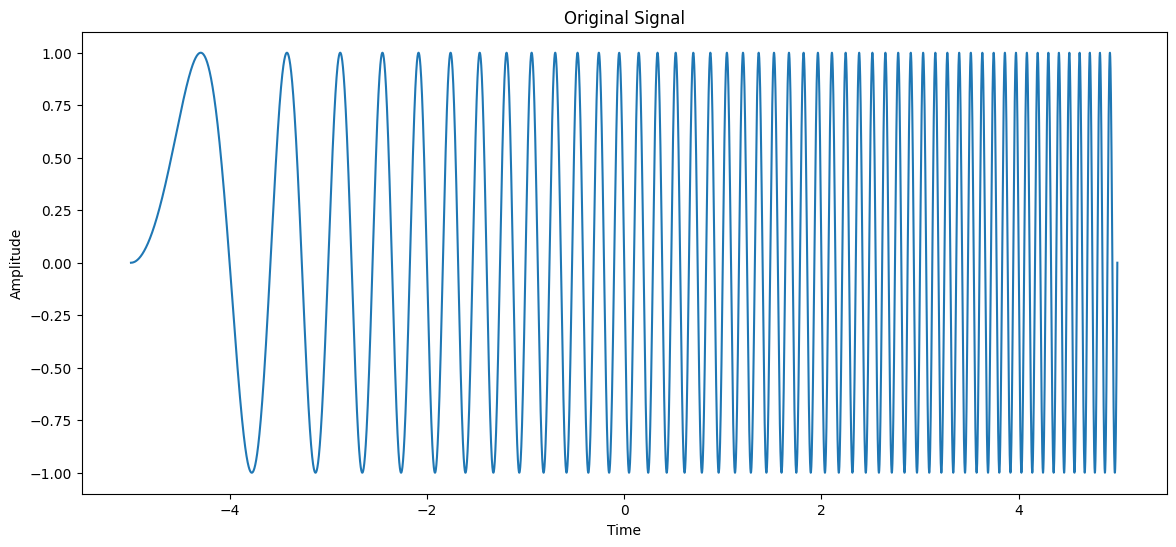

In [10]:
# Chirp signal down below
Fs = 20_000

# We add a chirp timstep in order to compute the chirp function, a normal timestep will not work

# TODO Change this, it does not work, should start from -5 to 5 and reach 15Hz at 5 seconds

def chirp(t,f0,f1,tmin,tmax):
    beta = (f0 - f1) / (tmax - tmin)
    alpha = (f1*tmax - f0*tmin) / (tmax - tmin)
    phase =  (beta/2)*((t+tmin)**2) + alpha*(t + tmin) 
    return np.sin(2*np.pi*phase)

# Now we compute the timesteps
timesteps = np.linspace(-100_000,100_000,10_000)/Fs
chirp_signal = chirp(timesteps,f0=15,tmin=-5,tmax=5,f1=5)

# Plotting the results below
plt.figure(figsize=(14, 6))
plt.plot(timesteps, chirp_signal)
plt.title('Original Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time')

Now create a Morlet wavelet with the following parameters:

* Center frequency of the wavelet = 10 Hz

* Sampling rate $\eta$ = 20000 Hz

* $k=\frac{1}{\sqrt{\eta}}$
* $\sigma = 0.2$
* Duration = 2 seconds


Text(0, 0.5, 'Amplitude')

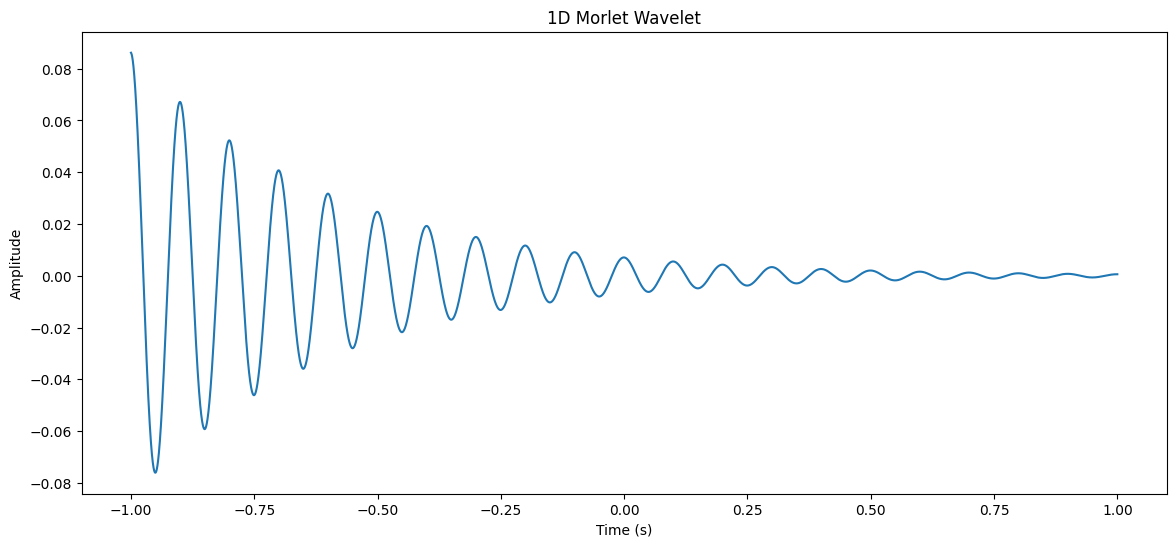

In [11]:
# Morlet Wavelet Here
eta = 20_000
timesteps = np.linspace(-eta,eta,10_000)/eta
sigma = 0.2
psi = (1/np.sqrt(eta)) * np.exp(2j*np.pi*10*timesteps) * np.exp((-1/2)*(timesteps/sigma))

# Plot the real part of the Morlet wavelet in 1D
plt.figure(figsize=(14, 6))

plt.plot(timesteps,np.real(psi))
plt.title('1D Morlet Wavelet')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

Compute the convolution between the signal and $Re(\Psi(t))$. For reference on how to perform convolution with scipy 'convolve' function, please check https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html

Text(0, 0.5, 'Amplitude')

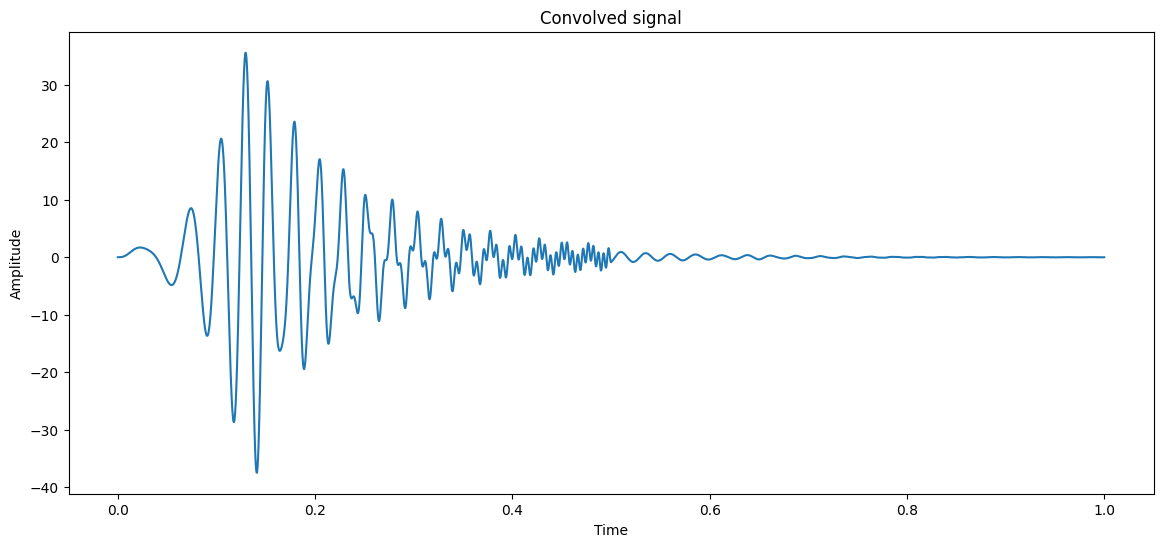

In [12]:
# Your code here
convolved_signal = sg.convolve(np.real(psi),chirp_signal)
timesteps = np.arange(len(convolved_signal))/Fs

# Plotting the reuslts
plt.figure(figsize=(14, 6))
plt.plot(timesteps, convolved_signal)
plt.title('Convolved signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

There are some points where the convolution is zero, even in regions of high similarity between the wavelet and the signal. **Is this OK?** If it's not, propose a solution to that.

Text(0, 0.5, 'Amplitude')

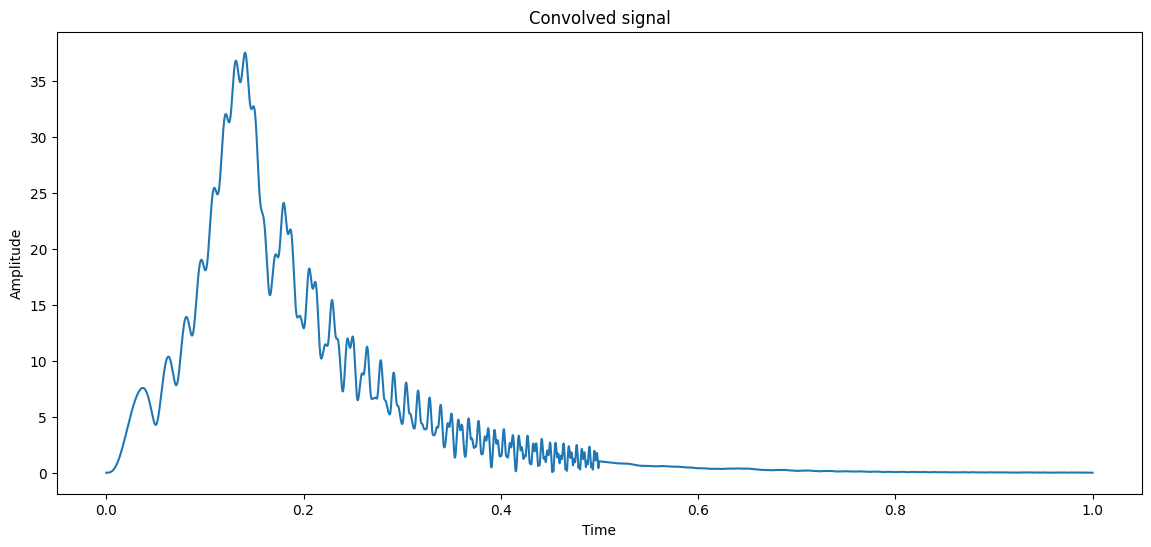

In [13]:
# Your code here
convolved_signal = sg.convolve(psi,chirp_signal)
timesteps = np.arange(len(convolved_signal))/Fs

# Plotting the reuslts
plt.figure(figsize=(14, 6))
plt.plot(timesteps, np.abs(convolved_signal))
plt.title('Convolved signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# **Image Compression**
For this part, we'll use the Discrete Wavelet Transform (DWT) implemented as a filter bank to do image compression. The first step is to have an image to compress. For doing so you can use the following piece of code to download an image of Trudy.

In [14]:
!wget https://raw.githubusercontent.com/jhonygiraldo/jhonygiraldo.github.io/main/Trudy_for_compression.jpeg

--2024-10-24 20:03:50--  https://raw.githubusercontent.com/jhonygiraldo/jhonygiraldo.github.io/main/Trudy_for_compression.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 557430 (544K) [image/jpeg]
Saving to: ‘Trudy_for_compression.jpeg.1’

Trudy_for_compressi 100%[===================>] 544.37K  --.-KB/s    in 0.1s    

2024-10-24 20:03:50 (4.64 MB/s) - ‘Trudy_for_compression.jpeg.1’ saved [557430/557430]



**Visualize image:** With the following code you can visualize the image. If you're using Google Collab, most probably you already have the open cv library installed. If you're using Jupyter Notebook for example, you'll have to install open cv if it's not already installed.

In [15]:
# Let us define a function for visualizing images
def show_image(image, title='Input Image', font_size=12,fig_size = (10, 10)):
  #A function that uses matplotlib to show grayscale images
  plt.figure(figsize=fig_size)
  plt.imshow(image, cmap='gray',interpolation='nearest')
  plt.title(title, fontsize=font_size)
  plt.axis('off')

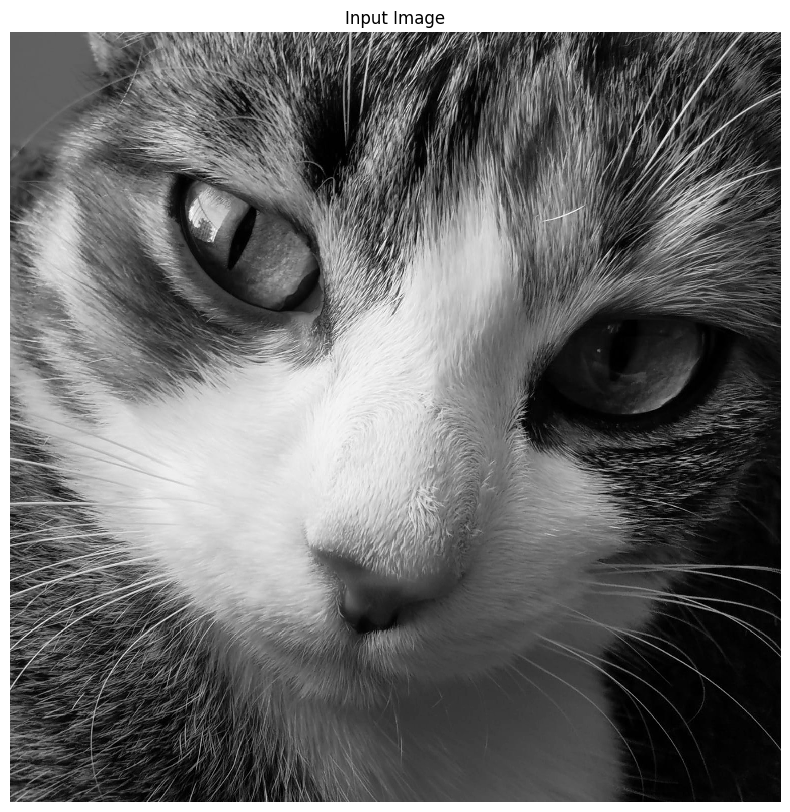

In [84]:
import cv2

# Load your image as a grayscale
input_image = cv2.imread('Trudy_for_compression.jpeg', cv2.IMREAD_GRAYSCALE)
# Display the original image
show_image(input_image, 'Input Image')

If you use some wavelet function (Biorthogonal 1.3 in this case), the 1-level 2D wavelet decomposition of our input image is given as follows:

In [17]:
# # You can see a list of wavelet families
import pywt
pywt.families()

['haar',
 'db',
 'sym',
 'coif',
 'bior',
 'rbio',
 'dmey',
 'gaus',
 'mexh',
 'morl',
 'cgau',
 'shan',
 'fbsp',
 'cmor']

In [18]:
# For each family, you can list the available wavelets
pywt.wavelist(family='db', kind='all')

['db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38']

In the previous image we applied a threshold in the wavelet coefficients for visualization purposes. **Please explain the meaning of each of these 4 images**.

**YOUR ANSWER HERE:**



Now, you should compute the six-levels 2D wavelet decomposition of the input image with a Daubechies wavelet with six vanishing moments using the PyWavelet library. Please check https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#d-multilevel-decomposition-using-wavedec2

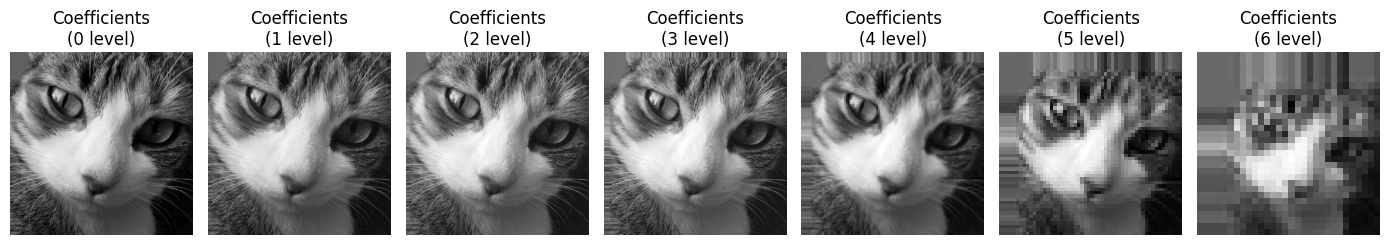

In [19]:
# The 2D wavelet decomposition is Here
#!danger here we use the 'db4' wave 


from pywt._doc_utils import draw_2d_wp_basis, wavedec2_keys

max_levels =   6  # how many levels of decomposition 
label_levels = 3  # how many levels to show on the 'burger' plots

fig, axes = plt.subplots(1, 7, figsize=[14, 8])

shape = input_image.shape

for level in range(max_levels + 1):

    # Let us compute the 2D DWT
    c = pywt.wavedec2(input_image, 'db4', level=level)
    modified_image = c[0]

    # We show the results
    arr, slices = pywt.coeffs_to_array(c)
    axes[level].imshow(modified_image, cmap=plt.cm.gray)
    axes[level].set_title(f'Coefficients\n({level} level)')
    axes[level].set_axis_off()

plt.tight_layout()
plt.show()


* Set a threshold of value of 100 and take to zero the values less than that in the 2D wavelet decomposition. **Note:** You should only threshold the outputs of the high-pass filters.



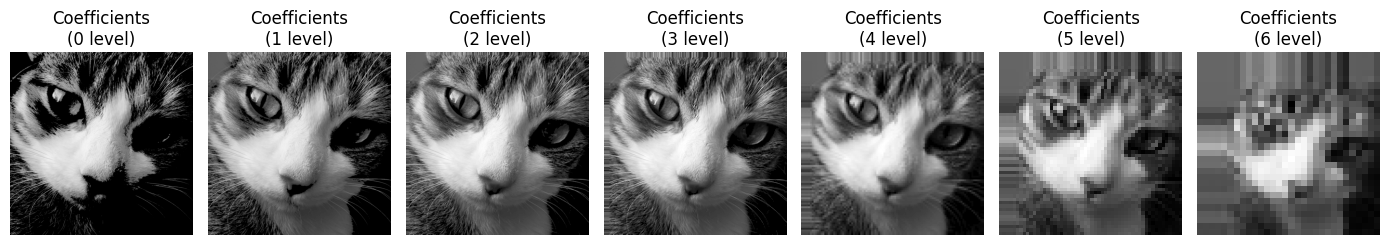

In [20]:
# Your code here
max_levels =   6  # how many levels of decomposition 
label_levels = 3  # how many levels to show on the 'burger' plots

fig, axes = plt.subplots(1, 7, figsize=[14, 8])

shape = input_image.shape

for level in range(max_levels + 1):

    # Let us compute the 2D DWT
    waved_image = pywt.wavedec2(input_image, 'db4', level=level)
    threshholded_image = pywt.threshold(data=waved_image[0], value=100, mode='greater')
    waved_image[0] = threshholded_image
    # We show the results
    axes[level].imshow(threshholded_image, cmap=plt.cm.gray)
    axes[level].set_title(f'Coefficients\n({level} level)')
    axes[level].set_axis_off()

plt.tight_layout()
plt.show()

* Compute the IDWT to reconstruct the image after the "compression". Check https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#d-multilevel-reconstruction-using-waverec2 as a reference.

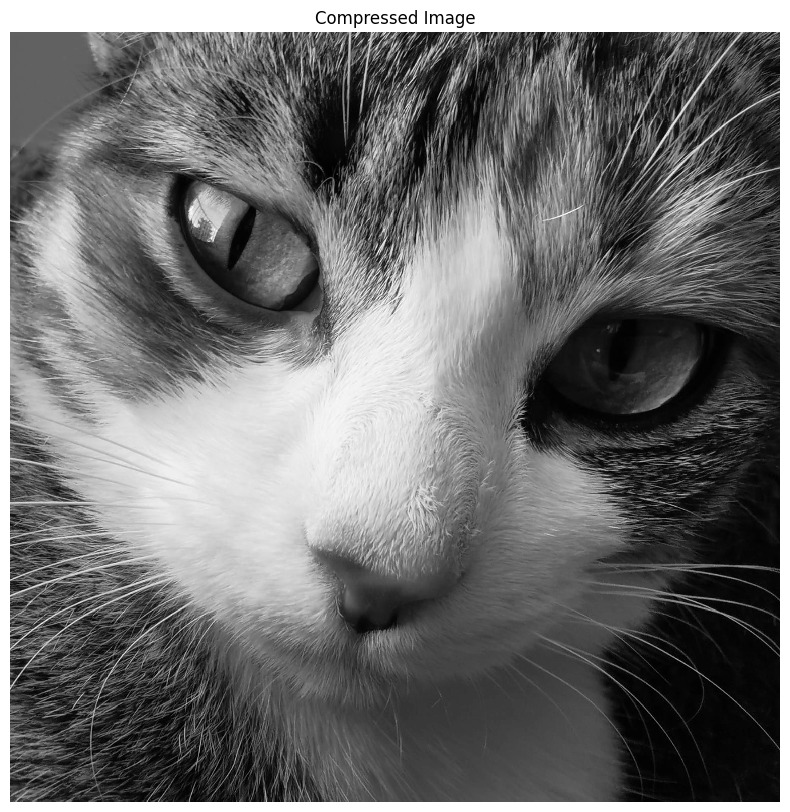

In [21]:
# here we will use the same image variable c
reconstructed_image = pywt.waverec2(waved_image,'db4')
#plot compressed image
show_image(reconstructed_image, 'Compressed Image')

What's the compression ratio?

In [32]:
# Compression ratio of the image
uncompressed_size = input_image.nbytes
compressed_size = reconstructed_image.nbytes
compression_ratio =  uncompressed_size/compressed_size
print(f'the compression ratio is equal to {compression_ratio}')

the compression ratio is equal to 0.12491840731070496


# **Putting everything together**

In this exercise we'll analyze the Peak Signal to Noise Ration (PSNR) of the compressed images for different thresholds. For doing so, we'll give you the function to compute the PSNR between the original and compressed image.

In [76]:
def psnr(original_image, compressed_image):
    h,w = original_image.shape
    mse = np.sum(np.abs(original_image-compressed_image)**2)/(h*w)
    return 20* np.log10(255**2/mse)

Now, you have to create a function codec that receives the input image, the wavelet to be used, the number of levels, and the threshold value. This function returns the compressed image and the compression ratio. **Note:** You already did that previously.

In [92]:
def codec(input_image,wavelet='db4',num_levels=6,threshold=100):
  # Your code here
  h,w = input_image.shape
  compressed_image = np.zeros((h,w))
  waved_image = pywt.wavedec2(input_image, wavelet=wavelet,level=level) 
  threshholded_image = pywt.threshold(data=waved_image[0], value=100, mode='greater')
  waved_image[0] = threshholded_image
  intermidiate_compressed_image = pywt.waverec2(waved_image,wavelet)
  compressed_image[:h,:w] = intermidiate_compressed_image[:h,:w]
  compression_ratio = input_image.nbytes/compressed_image.nbytes
  return compressed_image, compression_ratio

Now, we compare the performance of the 'db4' and the 'bior1.3' wavelets in terms of compression ratio and PSNR for different thresholds.

In [93]:
wavelet_1 = 'db4'
wavelet_2 = 'bior1.3'
thresholds = [5,10,20,40,80,100]
num_levels=6

# PSNR and performance of both wavelets
for threshhold in thresholds:

    db4_compression , db4_ratio= codec(input_image,
                                       wavelet=wavelet_1,
                                       num_levels=num_levels,
                                       threshold=threshhold)
    
    bior_compression , bior_ratio= codec(input_image,
                                       wavelet=wavelet_2,
                                       num_levels=num_levels,
                                       threshold=threshhold)
    
    
    print(f"- for a threshhold of {threshhold}")
    print("*********************************")
    print(f"the PSNR of db4 is {psnr(input_image,db4_compression)}")
    print(f"the PSNR of bior1.3 is {psnr(input_image,bior_compression)}")
    print("*********************************")
    print(f"the compression ratio of db4 is {db4_ratio}")
    print(f"the compression ratio bior is {bior_ratio}")
    if (db4_ratio>=bior_ratio):
        print(f"db4 compression has better performance for threshhold {threshhold}")
    else :
        print(f"bior1.3 compression has better performance for threshhold {threshhold}")
    print("**********************************")    
    

- for a threshhold of 5
*********************************
1531 1532
the PSNR of db4 is 119.90510014658433
1531 1532
the PSNR of bior1.3 is 150.36624643494824
*********************************
the compression ratio of db4 is 0.125
the compression ratio bior is 0.125
db4 compression has better performance for threshhold 5
**********************************
- for a threshhold of 10
*********************************
1531 1532
the PSNR of db4 is 119.90510014658433
1531 1532
the PSNR of bior1.3 is 150.36624643494824
*********************************
the compression ratio of db4 is 0.125
the compression ratio bior is 0.125
db4 compression has better performance for threshhold 10
**********************************
- for a threshhold of 20
*********************************
1531 1532
the PSNR of db4 is 119.90510014658433
1531 1532
the PSNR of bior1.3 is 150.36624643494824
*********************************
the compression ratio of db4 is 0.125
the compression ratio bior is 0.125
db4 compression h

**QUESTIONS**

1) Which wavelet is better for the Trudy_for_compression.jpeg image and why?

# Supplementary Exercises (Optional)
1. Designing and using custom filters with the pyWavelets library
Reference (https://pywavelets.readthedocs.io/en/latest/ref/wavelets.html#wavelet-families)
2. Propose and explore custom wavelets that achieve equivalent or higher compression ratio on the Trudy image explored previously. **P.S** You are free to explore any approach here.